<h1 align="center" style="background-color:#616161;color:white">Next play prediction</h1>

<h3 style="background-color:#616161;color:white">0. Setup code (you can ignore this section)</h3>

In [1]:
# import modules
%matplotlib inline
import csv
import os
import sys
import numpy as np
import pandas as pd
import datetime
from ggplot import *
import json
import time
import random
import sqlite3
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import logging

# Abs path to settings file
root = "C:/DS/Github/MusicRecommendation"  # BA, Windows
#root = "/home/badrul/Documents/github/MusicRecommendation" # BA, Linux

## Import the codebase module
fPath = root + "/1_codemodule"
if fPath not in sys.path: sys.path.append(fPath)


## Finish setting up
import coreCode as cb
import lastfmCode as fm

os.chdir(root)

settingsDict =  cb.loadSettings()

dbPath = root + settingsDict['mainDbPath']
fmSimilarDbPath = root + settingsDict['fmSimilarDbPath']
fmTagsDbPath = root + settingsDict['fmTagsDbPath']
trackMetaDbPath = root + settingsDict['trackmetadata']


In [2]:
def TimeSeriesPredict_FreqTable(playHistory, freqTable, w):
    # Takes in a timeslot list and a freqency table, and weighting for user obs
    # Returns next dd/mm/yy timestamp and probability
    # The timeslot list must be of the same format as  'timeSlot' field in freqTable
    
    playHistory.head()
    freqTable.head()
    
    return 0

def estBetaParams(mu, var):
  a = ((1 - mu) / var - 1 / mu) * mu**2
  b = a * (1 / mu - 1)
  return (a,b)

<h3 style="background-color:#616161;color:white">1. Model Parameters</h3>

In [3]:
# Method 1
PeriodGranularity = 60 # E.g. 15, 30, 60

# Train / Test split
MinsSincePrevPlay = 60   # Used when selecting random cut-off points in eval 1
newUsers = 10   # Num of randomly selected users to separate out of eval 2

<h3 style="background-color:#616161;color:white">2. Construct prior probability table

Our method for constructing the prior probability is calculate the total number of times a users started listening to music in a given time period, out of an estimaate of all the possible chances they had to play music in that time period. This latter item is hard to quantify as you may have weeks where the user does not listen to any music which you may not want to count. The approach used here is to count only weeks in which the user played any music, regardless of time period or number of times.

1. Brings back the frequency of plays by user. Note we ony count songs that were played after a gap of 'MinsSincePrevPlay'.

2. Calculates the total number of weeks in which each user played at least one track

3. Probability of play during period (i.e. hour of week) = # of plays in that period / total number of weeks

4. Note: For this to work, your MinsSincePrevPlay needs to be >= PeriodGranularity (e.g. if you were calculating your periods at the hourly level, but you treat any gap of 30 minutes as being a 'new play session', then you could be counting the numerator twiec and the denoninator onnce when determining the probability). 

5. TotalPlayCount (total number of sessions starts) is also calculated but not used.

In [52]:
con = sqlite3.connect(dbPath)
con.row_factory = sqlite3.Row
cursor = con.cursor()

# Fetch the frequency of plays
sqlStr = """Select userID, (strftime('%w',PlayedTimestamp)+1) || '-' || (strftime('%H',PlayedTimestamp))  
|| "-" || (cast(strftime('%M',PlayedTimestamp) / {} +1 as int)) as Period, count(*) 
as PlayCount from tblMain where MinsSincePrevPlay > {} group by userID, Period""".format(PeriodGranularity, MinsSincePrevPlay)

df = pd.read_sql_query(sqlStr, con)

# Fetch the total number of weeks each user has played music
sqlStr = "Select userID, count(DISTINCT (strftime('%W',PlayedTimestamp)||strftime('%Y',PlayedTimestamp))) as TotalWks from tblMain group by userID"
wks = pd.read_sql_query(sqlStr, con)
con.close()

# Calculate probability
df['TotalPlays'] = df.groupby('UserID')['PlayCount'].transform(sum)
df=df.set_index('UserID').join(wks.set_index('UserID'))
df['Prob'] = df['PlayCount'] / df['TotalWks']
df.reset_index(inplace=True)

# Calculate the parameters to be used in the Beta distribution later
meanvarDf= df.groupby('Period')['Prob'].mean().to_frame('mean')
meanvarDf['var'] = df.groupby('Period')['Prob'].var()

<h3 style="background-color:#616161;color:white">3. Check prior probability table

Let's do a few checks to make sure we've calculated the probabiloty correctly.

Check that the min/max is within 0-1 boundaries

In [26]:
df['Prob'].describe()

count    108959.000000
mean          0.072016
std           0.059748
min           0.004425
25%           0.029412
50%           0.057325
75%           0.097374
max           1.000000
Name: Prob, dtype: float64

Review using two users with small datasets. Note, 'Period' here is Day of week (Sunday = 1)-Hour of day-Period  (where Period is determined by the period Granulairty).

In [31]:
df[df.UserID == 61]

,UserID,Period,PlayCount,TotalPlays,TotalWks,Prob
7538,61,1-15-1,1,2,2,0.5
7539,61,5-20-1,1,2,2,0.5


In [30]:
df[df.UserID == 77]

,UserID,Period,PlayCount,TotalPlays,TotalWks,Prob
9380,77,2-09-1,1,13,6,0.166667
9381,77,2-13-1,1,13,6,0.166667
9382,77,3-02-1,1,13,6,0.166667
9383,77,3-08-1,1,13,6,0.166667
9384,77,3-13-1,1,13,6,0.166667
9385,77,3-17-1,1,13,6,0.166667
9386,77,4-06-1,1,13,6,0.166667
9387,77,4-09-1,1,13,6,0.166667
9388,77,4-11-1,1,13,6,0.166667
9389,77,4-20-1,1,13,6,0.166667


Let's do a histogram to see what the distribution looks like

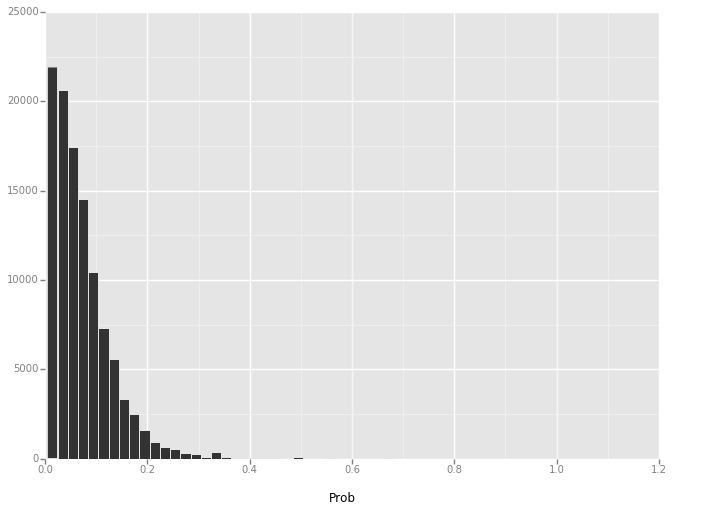

<ggplot: (-9223371916369257784)>

In [43]:
ggplot(aes(x='Prob'), data=df) + \
    geom_histogram(binwidth=0.02)

More crucially we can plot this distribution for a specific time-period which is what we will be comparing our Beta against later.

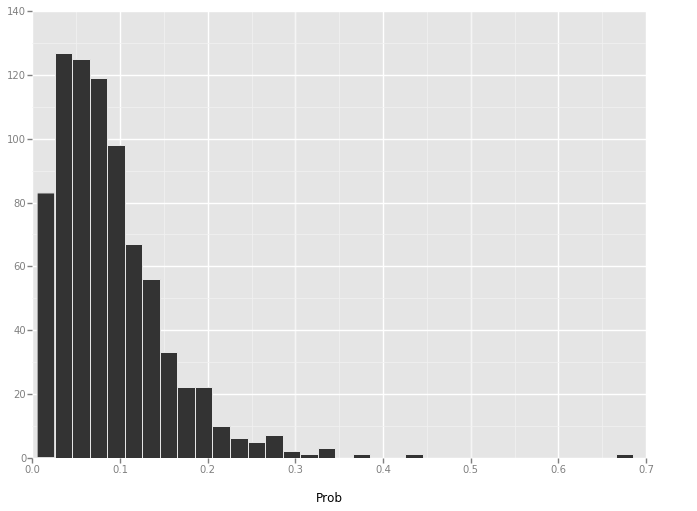

<ggplot: (120488905150)>

In [51]:
period='2-18-1'
ggplot(aes(x='Prob'), data=df[df.Period==period]) + \
    geom_histogram(binwidth=0.02)

Finally let's review the average probability for each time period

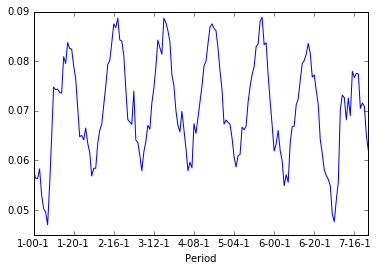

In [37]:
meanvarDf['mean'].plot()
#df.to_sql('tblPlayTimetable',con,if_exists='replace')  # Save to db

<h3 style="background-color:#616161;color:white">4. Assessing the fit for a Beta Posterior-Probability model

For any given period we can apply a Beta distribution to model the probability of someone wanting to listen to music in that time period. We can assess how well our Posterior-Probability distribution fit's using the log marginal liklihood measure. Let's start off looking at a single period (2-06-1) .

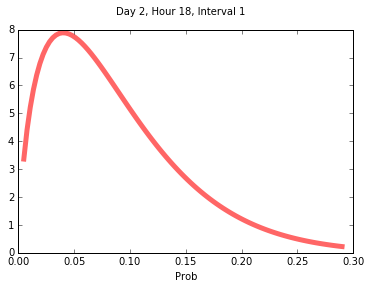

In [59]:
from scipy.stats import beta

p = '2-18-1'
mu = meanvarDf.loc[p]['mean']
var = meanvarDf.loc[p]['var']
a,b = estBetaParams(mu,var)

# Plot our prior Beta PDF
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)  # Generate prob distribution
ax.set_xlabel('Prob')
fig.suptitle('Day {}, Hour {}, Interval {}'.format(p[0],p[2:4],p[5]))
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6)

Recap:

* The x-axis for the beta prior represents the probability distribution of whether or not someone will start listening to music in that time period
* So the chart above indicates that the average probability is around 0.05 for Day 2, Hour 18:00
* We also have hisotircal data telling us what the actual probability was for that time period, both overall, and at an individual user leve

<h3 style="background-color:#616161;color:white">3. Review prior prob distribution</h3>

<h3 style="background-color:#616161;color:white">4. Evaluate model</h3>

In [120]:
con = sqlite3.connect(dbPath)
trainDF = pd.read_sql_query("SELECT M.UserID, M.PlayedTimestamp, M.TimeSlot, M.MinsSincePrevPlay, M.historyID, tblUsers.TestCutOff from tblMain as M INNER JOIN tblUsers ON M.UserID = tblUsers.UserID WHERE M.historyID < tblUsers.TestCutOff", con)
testDF = pd.read_sql_query("SELECT M.UserID, M.PlayedTimestamp, M.TimeSlot, M.MinsSincePrevPlay, M.historyID, tblUsers.TestCutOff from tblMain as M INNER JOIN tblUsers ON M.UserID = tblUsers.UserID WHERE M.historyID = tblUsers.TestCutOff", con)
users = trainDF['UserID'].unique()
con.close()